### Download data
Download data from ENA. We will look at a sample deposited by "some one" at
https://www.ebi.ac.uk/ena/data/view/PRJEB14532. Specifically, we will download the sequencing data from the Klebsiella pneumoniae 700603. The data are:
* MiSeq data: ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR147/008/ERR1474548/ERR1474548_1.fastq.gz and ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR147/008/ERR1474548/ERR1474548_2.fastq.gz
* Pacbio data:


To download a file from the internet, use `wget` from the console, or from a jupyter notebook with %%bash

In [1]:
%%bash
wget -c -q ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR147/008/ERR1474548/ERR1474548_2.fastq.gz

If you want to be a programmer and do not want to waste any resources, you might want to do like this:

In [2]:
%%bash
if [ -f ERR1474548_1.fastq.gz ]; then
    echo "File ERR1474548_1.fastq.gz has been downloaded"
else
    wget -c -q ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR147/008/ERR1474548/ERR1474548_1.fastq.gz
fi

File ERR1474548_1.fastq.gz has been downloaded


If you do not want to wait, you can play with data already in folder `/home/data/`

### QC
We can have a look at the data with our naked eye to have a sense of what data look like. Unix/Linux allows you to pipe multiple tools together with pipe |. such as

In [3]:
%%bash
zcat ERR1474548_1.fastq.gz | head

@ERR1474548.1 M00920:76:000000000-A7RKW:1:1101:15005:1000/1
NTCCCCAACATGCGACAGAGGATGGAGGCGGCATAGACCAGACGATNGGCACTGNAGANNNCCAGCNATNANCCAATAATTAACNGNGCCGTCGCTAANNGCATCTAAAGTCCTTTCTTCAGGTATAATCGTCGCCTCGCTGGGTTATCCCTACGCAGCGTAACGAATTCTTAATTTTGACTTTATGCGTGCCAAAAGTAAAACAAATGCCAGCTTTCGCNAACCTGTGCCTGTCTNNTATNCACATCTCCGAGCCCACGAGACCGTAATAGATCTCGTATGCCGTCTTCCGCTTGAAAAA
+
#8ACCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGC#:CFGGGG#:CF###::DFG#:C#:#:BFFGGGGGGGG#:#:BDEGGGGGGG##9:DFGGFGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGF8FGGGGGDGEEGGGGGGGGEGGGGGGGGCGGGGGGGGGFFFFDBEFFFFFFFFFFFFFFA@9EEEEFEFE<:3#(/6?FFFFFFFEA@)##--(#(,((44<AFFF(9B:119;9>FF0-((--)65<467<:0(<>>2(34>)(40313)92:
@ERR1474548.2 M00920:76:000000000-A7RKW:1:1101:18787:1000/1
NTTTAATCCCGAGGCCGAGCAGCACATTGGCGAAGCGGCACACGTCNGCATGCANTTCNNNGTAGGNGANGNGCTTGCTCTGGCNGNCGTCGTCGCCTNNCCAGATGATGGCGGTTTGATCGCCGCGCTCGGCGAGGTGGCGGTCGAGGCAGTTGGCGGCGAGGTTCAGGGTGCCGTCTTCATACCATTTGAAGGAAATGTTCACTTGCCCGAAGGAGGGNTTCTTCACGCGGGGGNNGGGNGGCATCCAGTCCAGGAATTTACCCTGCCAGCC

In the above, `zcat` will unzip the file on the fly, and `head` will show the first 10 lines. In a fastq file, a read is presented in 4 lines: Name, the read sequence, the sign +, and the quality. For understanding of the quality, please see https://en.wikipedia.org/wiki/FASTQ_format. The table below is from that page:


General, sequencing data from Illumina, and Miseq in particular, are in high quality. However, as can be easily be seen, the quality at the begining of the read is like F-G while at the end it is mostly ()0-9;. Furthermore, the data can contain adapter sequences. We can trim those low quality with trimmomatic.


### Assemble the genome
We can assemble the genome from sequencing data. The tool is `spades`. For interest of time, we will combine triming and running assembly in one cell


In [4]:
%%bash
#down sample data
zcat ERR1474548_1.fastq.gz | head -n 6000000 > D1.fastq
zcat ERR1474548_2.fastq.gz | head -n 6000000 > D2.fastq


trimmomatic PE -threads 8 -phred33 D1.fastq D2.fastq R1.fq.gz /dev/null R2.fq.gz /dev/null ILLUMINACLIP:/opt/conda/db/trimmomatic.fa:1:30:11 LEADING:3 TRAILING:3 MINLEN:30 TOPHRED33 

spades.py --pe1-1 R1.fq.gz --pe1-2 R2.fq.gz --only-assembler --threads 8 --memory 25 -o spades  -k 103,127                            

Command line: /opt/conda/bin/spades.py	--pe1-1	/home/jovyan/R1.fq.gz	--pe1-2	/home/jovyan/R2.fq.gz	--only-assembler	--threads	8	--memory	25	-o	/home/jovyan/spades	-k	103,127	

System information:
  SPAdes version: 3.13.2
  Python version: 3.6.8
  OS: Linux-4.14.138+-x86_64-with-debian-buster-sid

Output dir: /home/jovyan/spades
Mode: ONLY assembling (without read error correction)
Debug mode is turned OFF

Dataset parameters:
  Multi-cell mode (you should set '--sc' flag if input data was obtained with MDA (single-cell) technology or --meta flag if processing metagenomic dataset)
  Reads:
    Library number: 1, library type: paired-end
      orientation: fr
      left reads: ['/home/jovyan/R1.fq.gz']
      right reads: ['/home/jovyan/R2.fq.gz']
      interlaced reads: not specified
      single reads: not specified
      merged reads: not specified
Assembly parameters:
  k: [103, 127]
  Repeat resolution is enabled
  Mismatch careful mode is turned OFF
  MismatchCorrector will be SKIPP

TrimmomaticPE: Started with arguments:
 -threads 8 -phred33 D1.fastq D2.fastq R1.fq.gz /dev/null R2.fq.gz /dev/null ILLUMINACLIP:/opt/conda/db/trimmomatic.fa:1:30:11 LEADING:3 TRAILING:3 MINLEN:30 TOPHRED33
Using PrefixPair: 'AGATGTGTATAAGAGACAG' and 'AGATGTGTATAAGAGACAG'
Using PrefixPair: 'TACACTCTTTCCCTACACGACGCTCTTCCGATCT' and 'GTGACTGGAGTTCAGACGTGTGCTCTTCCGATCT'
Using Long Clipping Sequence: 'GTCTCGTGGGCTCGGAGATGTGTATAAGAGACAG'
Using Long Clipping Sequence: 'TCGTCGGCAGCGTCAGATGTGTATAAGAGACAG'
Using Long Clipping Sequence: 'AGATCGGAAGAGCTCGTATGCCGTCTTCTGCTTG'
Using Long Clipping Sequence: 'AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTA'
Skipping duplicate Clipping Sequence: 'AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTA'
Using Long Clipping Sequence: 'AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTAGATCTCGGTGGTCGCCGTATCATT'
Using Long Clipping Sequence: 'AGATCGGAAGAGCGGTTCAGCAGGAATGCCGAG'
Using Long Clipping Sequence: 'AGATCGGAAGAGCGGTTCAGCAGGAATGCCGAGACCGATCTCGTATGCCGTCTTCTGCTTG'
Using Long Clipping Sequence: 'TTTTTTT

This may take a while. How about we go back to some material of machine learning and will come back here!

INTERMISSION

Welcome back. Hope that you have the assembly ready in folder `spades`. No worries if you dont, because you can always copy the assembly from `data/spades/contigs.fasta`. We can have a look at the assembly. The first thing we want to do is see how good the assembly is. The statistics people often look at are N50 (minimum contig length needed to cover 50% of the genome)  number of contigs. While there are plenty of ready to use tool that can calculate this for you, I'd encourage you to write some code to do that. Let 's start with some python programming.


In [5]:
%%bash
wget -c -q ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/001/596/075/GCF_001596075.2_ASM159607v2/GCF_001596075.2_ASM159607v2_genomic.fna.gz 

In [6]:
#define a simple function for python to read in a contig file in fasta format
def read_fasta_simple(file_name):
    contigs= {}
    with open(file_name, 'r') as fn:
        seq = None
        name= None
        for line in fn:
            if line.startswith('>'):
                if name is not None:
                    contigs[name] = seq
                name = line.strip()[1:]
                seq = ''
            else:
                seq += line.strip()
    contigs[name] = seq
    return contigs

def calculate_N50_simple(ll):
    whole_length = sum(ll)
    s = 0
    for l in sorted(ll, reverse=True):
        s += l
        if s > whole_length / 2:
            return l


In [7]:
#Now we have the data, we can do some simple plotting to show the lengths of the contigs
assembly_name = '/home/jovyan/spades/contigs.fasta'
contigs = read_fasta_simple(assembly_name)

In [9]:
#Get the lengths of the all the contigs and do some very simple analyses
ll = [len(contigs[name]) for name in contigs]
          
print('Number of contigs is ', len(ll))
print('N50=',calculate_N50_simple(ll))

Number of contigs is  144
N50= 286110


In [10]:
%%bash
pip install matplotlib

  Using cached https://files.pythonhosted.org/packages/4e/11/06958a2b895a3853206dea1fb2a5b11bf044f626f90745987612af9c8f2c/matplotlib-3.1.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c0/0c/fc2e007d9a992d997f04a80125b0f183da7fb554f1de701bbb70a8e7d479/pyparsing-2.4.5-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f8/a1/5742b56282449b1c0968197f63eae486eca2c35dcd334bab75ad524e0de1/kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl


In [11]:
%matplotlib inline
import matplotlib.pylab as plt

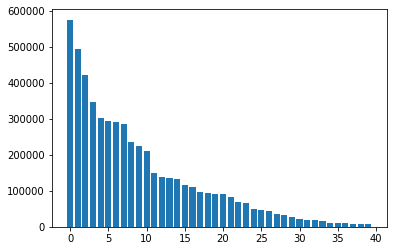

In [12]:
plt.bar(list(range(40)),sorted(ll,reverse=True)[:40]);

### Annotation
Now that we have assemmly of the genome, we can see if this bacterium has any genes through a step call annotation. Prokka is a great tool for genome annotation

In [13]:
%%bash
prokka --outdir prokka --force --genus Klebsiella --species pneumoniae --cpus 8 --fast --prefix Kp700603 spades/contigs.fasta

[10:46:49] This is prokka 1.14.5
[10:46:49] Written by Torsten Seemann <torsten.seemann@gmail.com>
[10:46:49] Homepage is https://github.com/tseemann/prokka
[10:46:49] Local time is Tue Dec 17 10:46:49 2019
[10:46:49] You are not telling me who you are!
[10:46:49] Operating system is linux
[10:46:49] You have BioPerl 1.007002
[10:46:49] System has 16 cores.
[10:46:49] Will use maximum of 8 cores.
[10:46:49] Annotating as >>> Bacteria <<<
[10:46:49] Generating locus_tag from 'spades/contigs.fasta' contents.
[10:46:49] Setting --locustag PBGJMELP from MD5 9b036e59b4fc68a855892e3f88a542b1
[10:46:49] Creating new output folder: prokka
[10:46:49] Running: mkdir -p prokka
[10:46:49] Using filename prefix: Kp700603.XXX
[10:46:49] Setting HMMER_NCPU=1
[10:46:49] Writing log to: prokka/Kp700603.log
[10:46:49] Command: /opt/conda/bin/prokka --outdir prokka --force --genus Klebsiella --species pneumoniae --cpus 8 --fast --prefix Kp700603 spades/contigs.fasta
[10:46:49] Appending to PATH: /opt/con

Now that you have to annotation of the genome, let have a look

# Variant calling

Sometimes, we want to compare a bacterial sample to an existing one that we know the reference. Instead of assembling the genome, we can call variant directly from sequencing reads. The pipeline often requires 1. mapping reads to the reference genome, and 2. call a variant calling program.


In [18]:
%%bash

#Let first download the reference genome

wget -c ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/349/285/GCF_000349285.2_G000_12282012/GCF_000349285.2_G000_12282012_genomic.fna.gz
gunzip    GCF_000349285.2_G000_12282012_genomic.fna.gz

--2019-12-17 10:59:47--  ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/349/285/GCF_000349285.2_G000_12282012/GCF_000349285.2_G000_12282012_genomic.fna.gz
           => ‘GCF_000349285.2_G000_12282012_genomic.fna.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 2607:f220:41e:250::10
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /genomes/all/GCF/000/349/285/GCF_000349285.2_G000_12282012 ... done.
==> SIZE GCF_000349285.2_G000_12282012_genomic.fna.gz ... 1683268
File has already been retrieved.
2019-12-17 10:59:49 (0.00 B/s) - ‘GCF_000349285.2_G000_12282012_genomic.fna.gz’ saved [1683268]



In [19]:
%%bash

#We will use bwa for alignment. We first need to index the reference
bwa index GCF_000349285.2_G000_12282012_genomic.fna

[bwa_index] Pack FASTA... 0.05 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 3.02 seconds elapse.
[bwa_index] Update BWT... 0.05 sec
[bwa_index] Pack forward-only FASTA... 0.03 sec
[bwa_index] Construct SA from BWT and Occ... 1.88 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index GCF_000349285.2_G000_12282012_genomic.fna
[main] Real time: 5.103 sec; CPU: 5.028 sec


In [20]:
%%bash
#Now that the reference is ready, we can proceed to alignment
bwa mem -t 8 GCF_000349285.2_G000_12282012_genomic.fna R1.fq.gz R2.fq.gz > Kp70600.sam
samtools view -b Kp70600.sam | samtools sort -o Kp70600.bam - && samtools index Kp70600.bam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 266004 sequences (80000241 bp)...
[M::process] read 266030 sequences (80000533 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (168, 108535, 10, 81)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (146, 235, 427)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 989)
[M::mem_pestat] mean and std.dev: (282.93, 191.60)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1270)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (342, 420, 543)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 945)
[M::mem_pestat] mean and std.dev: (453.36, 148.85)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1146)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) pe

For variant calling, we will use `freebayes`

In [22]:
%%bash
freebayes -r NZ_AOCV01000002.1:10000-20000 -f GCF_000349285.2_G000_12282012_genomic.fna -v variats.cvf Kp70600.bam